In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from api import SpotifyAPI

## Aquisição e conversão dos dados

In [2]:
# aquisição dos dados do spotify charts
dfs = []
for country in ['global', 'br', 'us', 'sa', 'jp']:
    path = f'data/regional_{country}_daily_latest.csv'
    dfs.append(pd.read_csv(path, sep=';').drop(['img'], axis=1))

In [3]:
# função que transforma o dtype da tabela
def stringfy(row):
    a, b, c, d, e = row[['url', 'position', 'track', 'artists', 'streams']].values
    return pd.Series({'url': str(a),
                      'position': int(b),
                      'track': str(c),
                      'artists': d,
                      'streams': int(e)})

In [4]:
# aplica a função nos dataframes
world, br, us, sa, jp = [x.apply(stringfy, axis=1) for x in dfs]

In [5]:
# lista com todos os dataframes
dfs = [world, br, us, sa, jp]

In [6]:
world.head()

,url,position,track,artists,streams
0,https://open.spotify.com/track/5PjdY0CKGZdEuoN...,1,STAY (with Justin Bieber),['The Kid LAROI'],9218788
1,https://open.spotify.com/track/27NovPIUIRrOZoC...,2,INDUSTRY BABY (feat. Jack Harlow),['Lil Nas X'],5803231
2,https://open.spotify.com/track/3Wrjm47oTz2sjIg...,3,Beggin',['Måneskin'],5591945
3,https://open.spotify.com/track/6PQ88X9TkUIAUIZ...,4,Bad Habits,['Ed Sheeran'],5192794
4,https://open.spotify.com/track/4ZtFanR9U6ndgdd...,5,good 4 u,['Olivia Rodrigo'],4851132


## API de busca da descrição de uma música

In [7]:
# instancia um objeto searcher da classe SpotifyAPI()
searcher = SpotifyAPI()

## Número de repetições entre as 200 mais tocadas

In [8]:
# número de repetições por região
streams = []
for df in dfs:
    stream = df['streams'].sum()
    streams.append(stream)
    print(stream)

271922802
40331467
68911289
870729
12430986


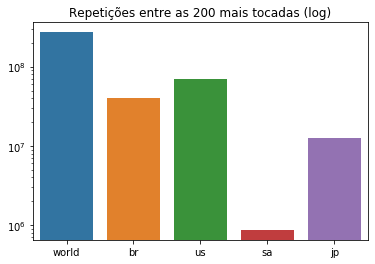

In [9]:
# gráfico do número de repetições entre as 200 músicas mais tocadas
sea.barplot(x=['world', 'br', 'us', 'sa', 'jp'], y=streams, log=True)
plt.title('Repetições entre as 200 mais tocadas (log)')
plt.show()

## Repetições por música

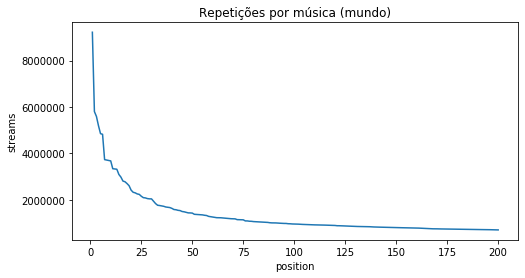

In [10]:
# Predominância de uma música sobre as outras (mundo)
plt.figure(figsize=[8, 4])
sea.lineplot(data=world, x='position', y='streams')
plt.title('Repetições por música (mundo)')
plt.show()

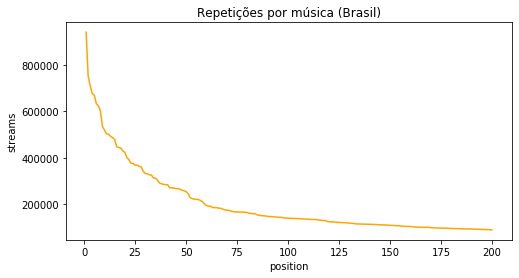

In [11]:
# Predominância de uma música sobre as outras (mundo)
plt.figure(figsize=[8, 4])
sea.lineplot(data=br, x='position', y='streams', color='orange')
plt.title('Repetições por música (Brasil)')
plt.show()

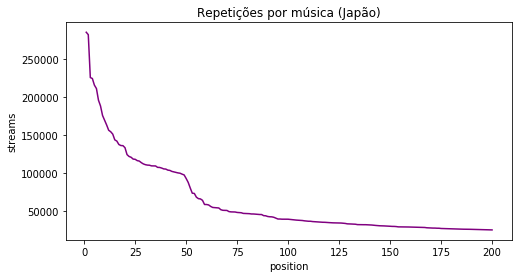

In [12]:
# Predominância de uma música sobre as outras (mundo)
plt.figure(figsize=[8, 4])
sea.lineplot(data=jp, x='position', y='streams', color='purple')
plt.title('Repetições por música (Japão)')
plt.show()

## Modelagem da popularidade das músicas

In [13]:
# função modelo 1
def exponential_1(x, a, b, c, d):
    return a*np.exp(-x/b + c) + d

# função modelo 2
def exponential_2(x, a, b, c, d):
    return a*np.exp(-x/b + c) + d/x

In [14]:
# exponential fit
popt_1, pcov_1 = scipy.optimize.curve_fit(exponential_1, np.array(range(1, 201)), np.array(world['streams']))
popt_2, pcov_2 = scipy.optimize.curve_fit(exponential_2, np.array(range(1, 201)), np.array(world['streams']))

In [15]:
# parametros do fit
print(popt_1)
print(popt_2)

[3.75507158e+02 1.58796502e+01 9.65147828e+00 9.10590434e+05]
[4.24182050e+01 1.07173487e+02 1.09712252e+01 7.62123319e+06]


In [16]:
# aplicando o fit nos dados
exp1_fit_world = [exponential_1(x, popt_1[0], popt_1[1], popt_1[2], popt_1[3]) for x in range(1, 201)]
exp2_fit_world = [exponential_2(x, popt_2[0], popt_2[1], popt_2[2], popt_2[3]) for x in range(1, 201)]

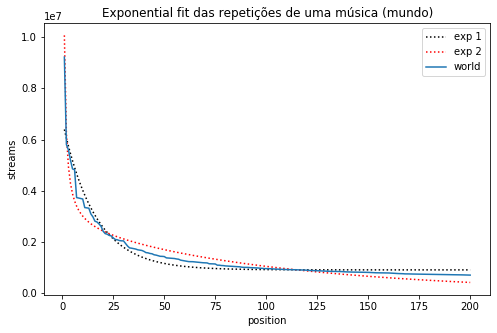

In [17]:
# comparação do fit com os dados reais
plt.figure(figsize=[8, 5])
sea.lineplot(x=range(1, 201), y=exp1_fit_world, color='black', linestyle=':')
sea.lineplot(x=range(1, 201), y=exp2_fit_world, color='red', linestyle=':')
sea.lineplot(data=world, x='position', y='streams')
plt.title('Exponential fit das repetições de uma música (mundo)')
plt.legend(['exp 1', 'exp 2', 'world'])
plt.show()